# Tully-Fisher Secondary Target Sample

In [96]:
import os
import csv
import numpy.ma as ma
from astropy.io import ascii, fits
from astropy.table import join, hstack, vstack, unique, Table, QTable, Column, setdiff
from astropy import constants as const
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy import units as u
from astropy import constants
from desispec.spectra import stack as specstack
from desispec.io import read_spectra, write_spectra

import psycopg2

import numpy as np
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt

import sqlite3
from contextlib import closing

#get rid of warnings for debugging ease
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [97]:
mpl.rc('font', size=16)
mpl.rc('axes', titlesize='small')

## SQLite3 Query

See if we have a cached copy of the query results (in FITS format) before running this query.

Use this query or the csv file to obtain the data.

In [3]:
# #Imports the DESI data that will be analyzed in this project
# tf_targets = Table.read('/global/project/projectdirs/desi/science/td/pv/pv_tf_targets.csv', format='ascii.csv')
# # tf_targets.write('tf_targets.fits', overwrite=True)
# len(tf_targets)

In [4]:
# Change use_cached = False if we want to redo the query at some point.
use_cached = True

if os.path.exists('TF_targets.fits') and use_cached:
    TF_targets = Table.read('TF_targets.fits')
else:
    try:
        db = psycopg2.connect(host='decatdb.lbl.gov', database='desi', user='desi')
        cursor = db.cursor()

        query = """SELECT DISTINCT pr.pvtype, pr.sga_id, fd.targetid, fd.target_ra, fd.target_dec, zd.z, zd.zerr, zd.spectype, zd.deltachi2, zd.zwarn, zd.yyyymmdd
                    FROM fibermap_daily fd
                    INNER JOIN
                        zbest_daily zd ON zd.targetid = fd.targetid
                    INNER JOIN
                        (SELECT targetid, MAX(expid) AS max_expid
                            FROM fibermap_daily
                            GROUP BY targetid) groupfmap
                            ON fd.targetid = groupfmap.targetid AND fd.expid = groupfmap.max_expid
                    INNER JOIN
                        (SELECT targetid, MAX(yyyymmdd) AS max_date
                            FROM zbest_daily
                            GROUP BY targetid) groupzd
                            ON zd.targetid = groupzd.targetid AND zd.yyyymmdd = groupzd.max_date
                    INNER JOIN pv.proposals pr ON (CAST(pr.ra*10000 AS INTEGER) = CAST(fd.target_ra*10000 AS INTEGER)) AND
                                                  (CAST(pr.dec*10000 AS INTEGER) = CAST(fd.target_dec*10000 AS INTEGER))
                    WHERE (pr.pvtype LIKE 'TFT' or pr.pvtype LIKE 'EXT' or pr.pvtype LIKE 'SGA')
                    ORDER BY zd.yyyymmdd;"""

        cursor.execute(query)
        rows = cursor.fetchall()
        TF_targets = Table(list(map(list, zip(*rows))),
                           names=['pvtype', 'sga_id', 'targetid', 'target_ra', 'target_dec', 'z', 'zerr', 'spectype', 'deltachi2', 'zwarn', 'yyyymmdd'])
        TF_targets.write('TF_targets.fits', overwrite=True)
        
    except (Exception, psycopg2.Exception) as error:
        print(error)
    finally:
        if db is not None:
            db.close()
            
TF_targets[:10]

pvtype,sga_id,targetid,target_ra,target_dec,z,zerr,spectype,deltachi2,zwarn,yyyymmdd
bytes3,int64,int64,float64,float64,float64,float64,bytes6,float64,int64,int64
SGA,227887,39628509848540752,34.8173069688145,31.3984950009448,0.0102383463580575,3.11491433701501e-07,GALAXY,332559.754650116,0,20201222
SGA,249627,39628473387452348,36.6378025591632,29.8305673331864,0.0349532879812339,6.64774044838025e-06,GALAXY,33952.1068879628,0,20201222
SGA,581116,39628499509579686,36.0846931600021,30.9513934451943,0.046449435766605,2.88855814568856e-06,GALAXY,53137.0094233155,0,20201222
SGA,879849,39628478600971508,34.0579702049385,30.0920453747291,0.0445682338630569,1.90017783907223e-06,GALAXY,33245.3577982187,0,20201222
SGA,1215253,39628494279282283,33.8598111259499,30.8583242268397,0.054035597680716,1.08280425883813e-05,GALAXY,11625.5793859102,0,20201222
SGA,1329026,39628478600971529,34.0593021182507,30.1224101637649,0.0296421307118722,5.19924224039755e-06,GALAXY,57099.7675513407,0,20201222
TFT,161400,39628462826195756,35.3790466101176,29.23051056593,0.0589073438874499,3.6126010927389e-06,GALAXY,12976.2707899213,0,20201222
TFT,173880,39628457541371020,35.7235330211126,28.8880073711485,0.0339580769142768,4.84624800995257e-06,GALAXY,4275.01541189849,0,20201222
TFT,356533,39628478613553751,34.884858293184,29.9153017059337,0.0350282773483738,1.87013308786851e-06,GALAXY,10878.9513677359,0,20201222


In [5]:
np.unique(TF_targets['pvtype'], return_counts=True)

(<Column name='pvtype' dtype='bytes3' length=3>
 EXT
 SGA
 TFT,
 array([   86,  6059, 13335]))

## Plot Target Coordinates

Constructs a map of the EXT, SGA, and TFT targets according to their RA and DEC coordinates.

In [6]:
def plot_radec(table):
    fig, ax = plt.subplots(1,1, figsize=(8,4), subplot_kw={'projection': 'mollweide'})
    class_names = np.unique(table['pvtype'])
    for class_name in class_names:
        select = table['pvtype'] == class_name
        _ra = np.radians(180. - table[select]['target_ra'])
        _dec = np.radians(table[select]['target_dec'])
        ax.scatter(_ra, _dec, alpha=0.5, s=5, label=class_name)
    ax.set(xticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
           xticklabels=['22h', '20h', '18h', '16h', '14h', '12h', '10h', '8h', '6h', '4h', '2h'])
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(ls=':')
    
    ax.legend(fontsize=8, loc='lower right')
    fig.tight_layout()

    return fig;

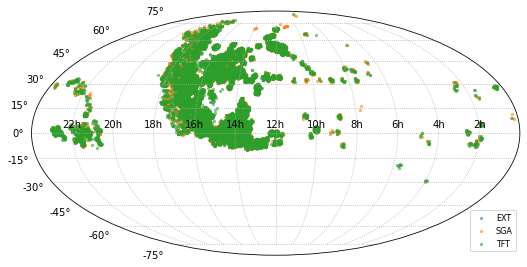

In [7]:
fig = plot_radec(TF_targets)

## Plot Target Redshifts

Extract good redshifts and plot the distributions as a function of target type.

In [8]:
isgoodz = (TF_targets['deltachi2']>= 25) & (TF_targets['zwarn']==0)
np.sum(isgoodz)

19480

In [9]:
redshiftCut = TF_targets[isgoodz]
redshiftCut[:10]

pvtype,sga_id,targetid,target_ra,target_dec,z,zerr,spectype,deltachi2,zwarn,yyyymmdd
bytes3,int64,int64,float64,float64,float64,float64,bytes6,float64,int64,int64
SGA,227887,39628509848540752,34.8173069688145,31.3984950009448,0.0102383463580575,3.11491433701501e-07,GALAXY,332559.754650116,0,20201222
SGA,249627,39628473387452348,36.6378025591632,29.8305673331864,0.0349532879812339,6.64774044838025e-06,GALAXY,33952.1068879628,0,20201222
SGA,581116,39628499509579686,36.0846931600021,30.9513934451943,0.046449435766605,2.88855814568856e-06,GALAXY,53137.0094233155,0,20201222
SGA,879849,39628478600971508,34.0579702049385,30.0920453747291,0.0445682338630569,1.90017783907223e-06,GALAXY,33245.3577982187,0,20201222
SGA,1215253,39628494279282283,33.8598111259499,30.8583242268397,0.054035597680716,1.08280425883813e-05,GALAXY,11625.5793859102,0,20201222
SGA,1329026,39628478600971529,34.0593021182507,30.1224101637649,0.0296421307118722,5.19924224039755e-06,GALAXY,57099.7675513407,0,20201222
TFT,161400,39628462826195756,35.3790466101176,29.23051056593,0.0589073438874499,3.6126010927389e-06,GALAXY,12976.2707899213,0,20201222
TFT,173880,39628457541371020,35.7235330211126,28.8880073711485,0.0339580769142768,4.84624800995257e-06,GALAXY,4275.01541189849,0,20201222
TFT,356533,39628478613553751,34.884858293184,29.9153017059337,0.0350282773483738,1.87013308786851e-06,GALAXY,10878.9513677359,0,20201222


In [10]:
redshiftCut.write('TF_targets.fits', overwrite=True)

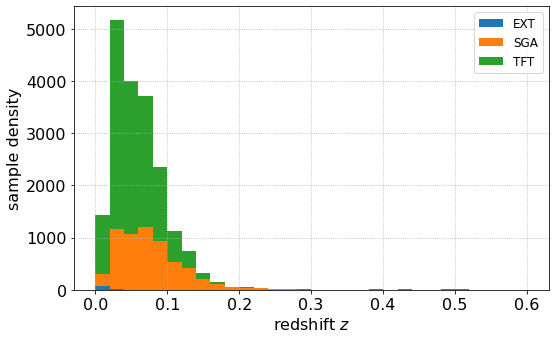

In [11]:
fig, ax = plt.subplots(1,1, figsize=(8,5), tight_layout=True)

zdata = []
pvtypes = np.unique(TF_targets['pvtype'])
for pvtype in pvtypes:
    ispvtype = TF_targets['pvtype'] == pvtype
    zdata.append(list(TF_targets[isgoodz & ispvtype]['z']))

zbins = np.linspace(0,0.6,31)
ax.hist(zdata, bins=zbins, stacked=True, label=pvtypes)
ax.set(#ylim=(0,15),
       xlabel='redshift $z$',
       ylabel='sample density')
ax.grid(ls=':')

ax.legend(fontsize=12);

## Read in list of PV Targets
PV targets from above desi query

In [83]:
PV_filename = 'TF_targets.fits'

hdu = fits.open(PV_filename)
print(hdu.info())
PV_observed = QTable(hdu[1].data)
hdu.close()

len(PV_observed)

Filename: TF_targets.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     30   19480R x 11C   [3A, K, K, D, D, D, D, 6A, D, K, K]   
None


19480

In [13]:
PV_observed[:10]

pvtype,sga_id,targetid,target_ra,target_dec,z,zerr,spectype,deltachi2,zwarn,yyyymmdd
str3,int64,int64,float64,float64,float64,float64,str6,float64,int64,int64
SGA,227887,39628509848540752,34.8173069688145,31.3984950009448,0.0102383463580575,3.11491433701501e-07,GALAXY,332559.754650116,0,20201222
SGA,249627,39628473387452348,36.6378025591632,29.8305673331864,0.0349532879812339,6.64774044838025e-06,GALAXY,33952.1068879628,0,20201222
SGA,581116,39628499509579686,36.0846931600021,30.9513934451943,0.046449435766605,2.88855814568856e-06,GALAXY,53137.0094233155,0,20201222
SGA,879849,39628478600971508,34.0579702049385,30.0920453747291,0.0445682338630569,1.90017783907223e-06,GALAXY,33245.3577982187,0,20201222
SGA,1215253,39628494279282283,33.8598111259499,30.8583242268397,0.054035597680716,1.08280425883813e-05,GALAXY,11625.5793859102,0,20201222
SGA,1329026,39628478600971529,34.0593021182507,30.1224101637649,0.0296421307118722,5.19924224039755e-06,GALAXY,57099.7675513407,0,20201222
TFT,161400,39628462826195756,35.3790466101176,29.23051056593,0.0589073438874499,3.6126010927389e-06,GALAXY,12976.2707899213,0,20201222
TFT,173880,39628457541371020,35.7235330211126,28.8880073711485,0.0339580769142768,4.84624800995257e-06,GALAXY,4275.01541189849,0,20201222
TFT,356533,39628478613553751,34.884858293184,29.9153017059337,0.0350282773483738,1.87013308786851e-06,GALAXY,10878.9513677359,0,20201222


## Identify SGA Galaxies

In [14]:
SGA_filename = '/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits'

hdu = fits.open(SGA_filename)
SGA = QTable(hdu[1].data)
hdu.close()

print(len(SGA))
SGA[:10]

383620


SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,2025p070,202.5

## Match DESI targets to SGA catalog

In [15]:
SGA_coords = SkyCoord(ra=SGA['RA']*u.degree, dec=SGA['DEC']*u.degree)
PV_coords = SkyCoord(ra=PV_observed['target_ra']*u.degree, dec=PV_observed['target_dec']*u.degree)

idx, sep2d, dist3d = match_coordinates_sky(PV_coords, SGA_coords, nthneighbor=1)

PV_observed['IDX_SGA'] = idx
PV_observed['SKY_TARGET_DIST_SGA'] = sep2d

### Stack the PV and SGA Tables

Make an `hstack` of the `PV_observed` and `SGA` tables using rows that matched PV coordinates to SGA centers. This will put all the relevant information into a single table that we'll call `PV_matched`.

In [16]:
PV_matched = hstack([PV_observed, SGA[idx]])

# Print the table to demonstrate that we've matched across the rows between PV_observed and SGA.
PV_matched[:10]

pvtype,sga_id,targetid,target_ra,target_dec,z,zerr,spectype,deltachi2,zwarn,yyyymmdd,IDX_SGA,SKY_TARGET_DIST_SGA,SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
str3,int64,int64,float64,float64,float64,float64,str6,float64,int64,int64,int64,float64,int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
SGA,227887,39628509848540752,34.8173069688145,31.3984950009448,0.0102383463580575,3.11491433701501e-07,GALAXY,332559.754650116,0,20201222,60758,4.493890748991992e-14,227887,SGA-2020 227887,PGC008852,8852,34.817458499999994,31.3985278,Sc,47.0,0.64565426,0.50699073,0.010257095,23.34948,15.671,False,LEDA-20181114,80819,PGC008852,1,True,34.817458499999994,31.3985278,0.64565426,0346p315,34.817306968814506,31.398495000944845,1.2628791,SB26,46.69509,0.44351774,34.817144987779656,31.39853435338646,27.821953,7.5643625,7.751205,8.018863,11.525722,14.140119,17.078676,20.250322,23.686016,27.286552,30.939543,34.54722,37.886375,15.656424,14.952178,14.416003,15.541749,14.834224,14.296817,15.452583,14.743252,14.206147,15.386299,14.674229,14.137649,15.334078,14.620995,14.084178,15.295982,14.582026,14.045881,15.268926,14.553481,14.018,15.249975,14.534507,13.997845,15.23794,14.522351,13.984281,0.037277393,0.061759222,0.063091725,0.10513751,0.068378456,0.08847286,0.11017215,0.1338445,0.14169279,0.013537007,0.01256346,0.011847482,0.012311069,0.011419123,0.010781854,0.011420003,0.010592375,0.010021184,0.010789593,0.009995378,0.009472868,0.010305492,0.009542425,0.00904329



#### Matching SGA IDs?

Making the `hstack` of the `PV_observed` and `SGA` tables changes some of the columns in the merged table. After the stack:
- `SGA_ID` in `PV_observed` becomes `SGA_ID_1`. This corresponds to the SGA ID returned by the database query of TF targets at NERSC.
- `SGA_ID` in `SGA` becomes `SGA_ID_2` in the merged table. This is the SGA ID of the galaxy that is the nearest neighbor of the DESI target in each row of the merged table.

Note that many if not most of the `SGA_ID_1` values will be zero b/c that's what is returned by the current query (as of end of June 2021). Here we check that when `SGA_ID_1` is nonzero, then it matches `SGA_ID_2`. For cases that don't match, it may be due to the fact that the correct SGA ID is *not* the nearest neighbor of that particular DESI target. 

In [17]:
# Grab a boolean array where the sga_id is nonzero.
is_nonzero_id = PV_matched['sga_id'] != 0

# For all rows where sga_id is nonzero, print sga_id and SGA_ID.
PV_matched[is_nonzero_id]['sga_id', 'SGA_ID'][:10]

sga_id,SGA_ID
int64,int64
227887,227887
249627,249627
581116,581116
879849,879849
1215253,1215253
1329026,1329026
161400,161400
173880,173880
356533,356533


In [18]:
diff_id = PV_matched['sga_id'] != PV_matched['SGA_ID']
PV_matched = PV_matched[~diff_id]
PV_matched

pvtype,sga_id,targetid,target_ra,target_dec,z,zerr,spectype,deltachi2,zwarn,yyyymmdd,IDX_SGA,SKY_TARGET_DIST_SGA,SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
str3,int64,int64,float64,float64,float64,float64,str6,float64,int64,int64,int64,float64,int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
SGA,227887,39628509848540752,34.8173069688145,31.3984950009448,0.0102383463580575,3.11491433701501e-07,GALAXY,332559.754650116,0,20201222,60758,4.493890748991992e-14,227887,SGA-2020 227887,PGC008852,8852,34.817458499999994,31.3985278,Sc,47.0,0.64565426,0.50699073,0.010257095,23.34948,15.671,False,LEDA-20181114,80819,PGC008852,1,True,34.817458499999994,31.3985278,0.64565426,0346p315,34.817306968814506,31.398495000944845,1.2628791,SB26,46.69509,0.44351774,34.817144987779656,31.39853435338646,27.821953,7.5643625,7.751205,8.018863,11.525722,14.140119,17.078676,20.250322,23.686016,27.286552,30.939543,34.54722,37.886375,15.656424,14.952178,14.416003,15.541749,14.834224,14.296817,15.452583,14.743252,14.206147,15.386299,14.674229,14.137649,15.334078,14.620995,14.084178,15.295982,14.582026,14.045881,15.268926,14.553481,14.018,15.249975,14.534507,13.997845,15.23794,14.522351,13.984281,0.037277393,0.061759222,0.063091725,0.10513751,0.068378456,0.08847286,0.11017215,0.1338445,0.14169279,0.013537007,0.01256346,0.011847482,0.012311069,0.011419123,0.010781854,0.011420003,0.010592375,0.010021184,0.010789593,0.009995378,0.009472868,0.010305492,0.009542425,0.00904329

## Histogram of matched DESI and SGA data

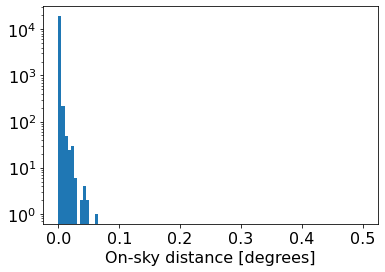

In [19]:
plt.figure()

plt.hist(PV_matched['SKY_TARGET_DIST_SGA'].data, bins=np.linspace(0, 0.5, 100))
#plt.hist(PV_SGA_observed['SKY_TARGET_DIST_SGA'].data, bins=np.linspace(0,1,100))

plt.yscale('log')

plt.xlabel('On-sky distance [degrees]');

## Define a function to evaluate arbitrary SGA ellipses

This provides a check to make sure that the TF targets actually fall within the SGA galaxy that `match_coordinates_sky` assigns them to. The results of the check show that `match_coordinates_sky` correctly matched all 25,497 TF targets with their galaxy using `nthneighbor=1`.

In [20]:
diameter = PV_matched['D26']
PA = PV_matched['PA']*(np.pi/180)
BA = PV_matched['BA']

center_ra = (PV_matched['RA'])/(np.cos(PV_matched['DEC']*(np.pi/180)))
center_dec = PV_matched['DEC']
ra_observed = (PV_matched['target_ra'])/(np.cos(PV_matched['target_dec']*(np.pi/180)))
dec_observed = PV_matched['target_dec']

B = PV_matched['BA']*(0.5*diameter)
A = B*(1/(PV_matched['BA']))

In [21]:
C = ((ra_observed - center_ra)*np.cos(PA))+((dec_observed - center_dec)*np.sin(PA))
D = ((dec_observed - center_dec)*np.cos(PA))-((ra_observed - center_ra)*np.sin(PA))
ellipse = ((C**2)/(A**2)) + ((D**2)/(B**2))
good_boolean = ellipse <= 1
galaxy_targets = PV_matched[good_boolean]

print('The SGA crossmatch correctly matches', len(galaxy_targets), 'out of the', len(PV_matched), 'DESI targets.') 

The SGA crossmatch correctly matches 19464 out of the 19464 DESI targets.


In [22]:
galaxy_targets[:10]

pvtype,sga_id,targetid,target_ra,target_dec,z,zerr,spectype,deltachi2,zwarn,yyyymmdd,IDX_SGA,SKY_TARGET_DIST_SGA,SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
str3,int64,int64,float64,float64,float64,float64,str6,float64,int64,int64,int64,float64,int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
SGA,227887,39628509848540752,34.8173069688145,31.3984950009448,0.0102383463580575,3.11491433701501e-07,GALAXY,332559.754650116,0,20201222,60758,4.493890748991992e-14,227887,SGA-2020 227887,PGC008852,8852,34.817458499999994,31.3985278,Sc,47.0,0.64565426,0.50699073,0.010257095,23.34948,15.671,False,LEDA-20181114,80819,PGC008852,1,True,34.817458499999994,31.3985278,0.64565426,0346p315,34.817306968814506,31.398495000944845,1.2628791,SB26,46.69509,0.44351774,34.817144987779656,31.39853435338646,27.821953,7.5643625,7.751205,8.018863,11.525722,14.140119,17.078676,20.250322,23.686016,27.286552,30.939543,34.54722,37.886375,15.656424,14.952178,14.416003,15.541749,14.834224,14.296817,15.452583,14.743252,14.206147,15.386299,14.674229,14.137649,15.334078,14.620995,14.084178,15.295982,14.582026,14.045881,15.268926,14.553481,14.018,15.249975,14.534507,13.997845,15.23794,14.522351,13.984281,0.037277393,0.061759222,0.063091725,0.10513751,0.068378456,0.08847286,0.11017215,0.1338445,0.14169279,0.013537007,0.01256346,0.011847482,0.012311069,0.011419123,0.010781854,0.011420003,0.010592375,0.010021184,0.010789593,0.009995378,0.009472868,0.010305492,0.009542425,0.00904329

## Grace's attempt to calculate rotation velocities

For a given SGA galaxy, we can match that center with all other rows in the targets data file that have the same SGA ID. These include the TFT and EXT targets. The goal is to find SGA observations with at least one TFT or EXT target.

The distance and velocity must be calculated for the repeated SGA IDs to later use in plotting on the MaNGA rotation curves.

In [23]:
# PV_fiber_coords = SkyCoord(ra=PV_matched['FIBER_RA']*u.degree, 
#                            dec=PV_matched['FIBER_DEC']*u.degree)

# PV_matched['SKY_FIBER_DIST_SGA'] = PV_fiber_coords.separation(SGA_coords[PV_matched['IDX_SGA']])

In [24]:
def rot_vel(targets):
    ''''
    Calculates the rotation velocity for each observation in a table given redshift measurments for the target and the
    corresponding galactic center.
   
    Parameters- 
        targets: astropy table containing the DESI observations for an SGA galaxy. Must include redshift -z- and the 
        distance between the DESI and SGA object -SKY_TARGET_DIST_SGA.

    '''
    center_idx = np.argmin(targets['SKY_TARGET_DIST_SGA'])
    targets['rot_vel'] = np.abs(const.c.to('km/s')*(targets['z'] - targets[center_idx]['z']))
    targets['V_ROT_ERR'] = const.c.to('km/s')*np.sqrt(targets['zerr']**2 + targets[center_idx]['zerr']**2)
    #print("NoTargets, ", len(targets), ". CenterIndex, ", center_idx, ". CenterValue, ",targets[center_idx]['z'])
    return targets

In [25]:
unique = np.unique(PV_matched['IDX_SGA'])
len(unique)

16433

In [26]:
PV_matched

pvtype,sga_id,targetid,target_ra,target_dec,z,zerr,spectype,deltachi2,zwarn,yyyymmdd,IDX_SGA,SKY_TARGET_DIST_SGA,SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
str3,int64,int64,float64,float64,float64,float64,str6,float64,int64,int64,int64,float64,int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
SGA,227887,39628509848540752,34.8173069688145,31.3984950009448,0.0102383463580575,3.11491433701501e-07,GALAXY,332559.754650116,0,20201222,60758,4.493890748991992e-14,227887,SGA-2020 227887,PGC008852,8852,34.817458499999994,31.3985278,Sc,47.0,0.64565426,0.50699073,0.010257095,23.34948,15.671,False,LEDA-20181114,80819,PGC008852,1,True,34.817458499999994,31.3985278,0.64565426,0346p315,34.817306968814506,31.398495000944845,1.2628791,SB26,46.69509,0.44351774,34.817144987779656,31.39853435338646,27.821953,7.5643625,7.751205,8.018863,11.525722,14.140119,17.078676,20.250322,23.686016,27.286552,30.939543,34.54722,37.886375,15.656424,14.952178,14.416003,15.541749,14.834224,14.296817,15.452583,14.743252,14.206147,15.386299,14.674229,14.137649,15.334078,14.620995,14.084178,15.295982,14.582026,14.045881,15.268926,14.553481,14.018,15.249975,14.534507,13.997845,15.23794,14.522351,13.984281,0.037277393,0.061759222,0.063091725,0.10513751,0.068378456,0.08847286,0.11017215,0.1338445,0.14169279,0.013537007,0.01256346,0.011847482,0.012311069,0.011419123,0.010781854,0.011420003,0.010592375,0.010021184,0.010789593,0.009995378,0.009472868,0.010305492,0.009542425,0.00904329

In [27]:
PV_SGA_table = None

for i in np.unique(PV_matched['IDX_SGA']):
    idx_bool = PV_matched['IDX_SGA'] == i
    matched_targets = PV_matched[idx_bool]
    if len(matched_targets)>1 and len(np.unique(matched_targets['targetid'])>1):
        matched_targets = rot_vel(matched_targets)
        
        if PV_SGA_table == None:
            PV_SGA_table = matched_targets
        else:
            PV_SGA_table = vstack([PV_SGA_table, matched_targets])

In [28]:
print(len(PV_SGA_table))
PV_SGA_table[:10]

4458


pvtype,sga_id,targetid,target_ra,target_dec,z,zerr,spectype,deltachi2,zwarn,yyyymmdd,IDX_SGA,SKY_TARGET_DIST_SGA,SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,rot_vel,V_ROT_ERR
,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,km / s,km / s
str3,int64,int64,float64,float64,float64,float64,str6,float64,int64,int64,int64,float64,int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64
TFT,896,39627817951955633,180.381827027663,1.29582683075782,0.0224268882804446,2.38327894423635e-05,GALAXY,282.609595151269,0,20210405,256,4.830690533845092e-13,896,SGA-2020 896,PGC1190469,1190469,180.38184750000002,1.2958311000000002,Sc,76.42,0.44771332,0.7726806,0.022478215,23.47448,16.591,False,LEDA-20181114,256,PGC1190469,1,True,180.38184750000002,1.2958311000000002,0.44771332,1803p012,180.38182702766252,1.2958268307578154,0.6239483,SB26,76.93204,0.79918337,180.38178401011206,1.295990493861164,16.25661,7.6343946,7.3312407,7.215459,4.267071,6.71145,8.98399,11.085844,12.783826,14.283976,15.799797,17.191736,18.718449,18.022089,17.380363,16.982048,17.370085,16.760023,16.377943,16.967363,16.3918,16.024693,16.728146,16.17214,15.817478,16.609686,16.06539,15.715597,16.54587,16.008068,15.658699,16.505327,15.967604,15.619181,16.48057,15.942226,15.594475,16.459711,15.924162,15.572447,0.02403138,0.037713606,0.06752815,0.0597593,0.041663416,0.057950046,0.06897008,0.07238169,0.11818266,0.0070740557,0.008179923,0.008415725,0.005835994,0.006626628,0.0068130954,0.0056522293,0.006152283,0.0062183426,0.0057331356,0.0

In [29]:
#Calculate the distance from the galactic center and the velocity for the repeated SGA galaxies
sep_r26 = PV_SGA_table['SKY_TARGET_DIST_SGA'].to('arcmin')/(0.5*PV_SGA_table['D26']*u.arcmin)
print(sep_r26)

[9.29055959e-11 3.29999998e-01 8.53314518e-11 ... 3.29999999e-01
 1.31124280e-03 1.16333204e-10]


In [30]:
#adds a column for the distance to the galactic centers 
PV_SGA_table['r_gcenter'] = sep_r26
PV_SGA_table[:10]

pvtype,sga_id,targetid,target_ra,target_dec,z,zerr,spectype,deltachi2,zwarn,yyyymmdd,IDX_SGA,SKY_TARGET_DIST_SGA,SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,rot_vel,V_ROT_ERR,r_gcenter
,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,km / s,km / s,
str3,int64,int64,float64,float64,float64,float64,str6,float64,int64,int64,int64,float64,int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64
TFT,896,39627817951955633,180.381827027663,1.29582683075782,0.0224268882804446,2.38327894423635e-05,GALAXY,282.609595151269,0,20210405,256,4.830690533845092e-13,896,SGA-2020 896,PGC1190469,1190469,180.38184750000002,1.2958311000000002,Sc,76.42,0.44771332,0.7726806,0.022478215,23.47448,16.591,False,LEDA-20181114,256,PGC1190469,1,True,180.38184750000002,1.2958311000000002,0.44771332,1803p012,180.38182702766252,1.2958268307578154,0.6239483,SB26,76.93204,0.79918337,180.38178401011206,1.295990493861164,16.25661,7.6343946,7.3312407,7.215459,4.267071,6.71145,8.98399,11.085844,12.783826,14.283976,15.799797,17.191736,18.718449,18.022089,17.380363,16.982048,17.370085,16.760023,16.377943,16.967363,16.3918,16.024693,16.728146,16.17214,15.817478,16.609686,16.06539,15.715597,16.54587,16.008068,15.658699,16.505327,15.967604,15.619181,16.48057,15.942226,15.594475,16.459711,15.924162,15.572447,0.02403138,0.037713606,0.06752815,0.0597593,0.041663416,0.057950046,0.06897008,0.07238169,0.11818266,0.0070740557,0.008179923,0.008415725,0.005835994,0.006626628,0.0068130954,0.0056522293,0.006152283,0.00621834

In [31]:
#This step eliminates unrealistic rotatation velocities. 
good_velocities = PV_SGA_table['rot_vel'] < 1000*u.km/u.second 
final_data = PV_SGA_table[good_velocities]

print(len(final_data))
final_data[:10]

4269


pvtype,sga_id,targetid,target_ra,target_dec,z,zerr,spectype,deltachi2,zwarn,yyyymmdd,IDX_SGA,SKY_TARGET_DIST_SGA,SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,rot_vel,V_ROT_ERR,r_gcenter
,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,km / s,km / s,
str3,int64,int64,float64,float64,float64,float64,str6,float64,int64,int64,int64,float64,int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64
TFT,896,39627817951955633,180.381827027663,1.29582683075782,0.0224268882804446,2.38327894423635e-05,GALAXY,282.609595151269,0,20210405,256,4.830690533845092e-13,896,SGA-2020 896,PGC1190469,1190469,180.38184750000002,1.2958311000000002,Sc,76.42,0.44771332,0.7726806,0.022478215,23.47448,16.591,False,LEDA-20181114,256,PGC1190469,1,True,180.38184750000002,1.2958311000000002,0.44771332,1803p012,180.38182702766252,1.2958268307578154,0.6239483,SB26,76.93204,0.79918337,180.38178401011206,1.295990493861164,16.25661,7.6343946,7.3312407,7.215459,4.267071,6.71145,8.98399,11.085844,12.783826,14.283976,15.799797,17.191736,18.718449,18.022089,17.380363,16.982048,17.370085,16.760023,16.377943,16.967363,16.3918,16.024693,16.728146,16.17214,15.817478,16.609686,16.06539,15.715597,16.54587,16.008068,15.658699,16.505327,15.967604,15.619181,16.48057,15.942226,15.594475,16.459711,15.924162,15.572447,0.02403138,0.037713606,0.06752815,0.0597593,0.041663416,0.057950046,0.06897008,0.07238169,0.11818266,0.0070740557,0.008179923,0.008415725,0.005835994,0.006626628,0.0068130954,0.0056522293,0.006152283,0.00621834

## MaNGA and SGA Crossmatch

Download the MaNGA data from the following URL and import it as a .txt file: http://www.pas.rochester.edu/~kdouglass/Research/data/DRP-master_file_vflag_BB_smooth1p85_mapFit_N2O2_HIdr2_noWords_v5.txt

See the following Jupyter notebook for the crossmatch of the MaNGA data with the SGA-2020 catalog:
https://github.com/gracechiodo/tf_spiral_galaxy/blob/main/MaNGA_SGA_crossmatch.ipynb

In [32]:
SGA_MaNGA = Table.read('MaNGA_SGA_data.txt', format='ascii.commented_header')
print(len(SGA_MaNGA))
SGA_MaNGA[:10]

62


MaNGA_plate_1,MaNGA_IFU_1,plateifu,v_sys,v_sys_err,ba,ba_err,x0,x0_err,y0,y0_err,phi,phi_err,r_turn,r_turn_err,v_max,v_max_err,chi2,alpha,alpha_err,nsa_elpetro_th90,fit_flag,smoothness_score_1,M90,M90_err,MaNGA_plate_2,MaNGA_IFU_2,NSA_plate,NSA_fiberID,NSA_MJD,NSA_index,NSA_RA,NSA_DEC,NSA_ba,NSA_phi,NSA_redshift,NSA_Mstar,vflag,avg_v_max,avg_v_max_sigma,avg_alpha,avg_alpha_sigma,avg_chi_square_rot,pos_v_max,pos_v_max_sigma,pos_alpha,pos_alpha_sigma,pos_chi_square_rot,neg_v_max,neg_v_max_sigma,neg_alpha,neg_alpha_sigma,neg_chi_square_rot,center_flux,center_flux_error,Mtot,Mtot_error,Mdark,Mdark_error,Mstar,Mdark_Mstar_ratio,Mdark_Mstar_ratio_error,rabsmag,avg_r_turn,avg_r_turn_sigma,pos_r_turn,pos_r_turn_sigma,neg_r_turn,neg_r_turn_sigma,logNO,t3,BPT,curve_used,points_cut,avg_chi_square_ndf,pos_chi_square_ndf,neg_chi_square_ndf,index,Z12logOH,u_r,frac_masked_spaxels,Rmax,Mtot_Mstar_ratio,Mtot_Mstar_ratio_error,smoothness_score_2,pos_Vmax_data,avg_Vmax_data,neg_Vmax_data,ba_map,ba_err_map,phi_map,phi_err_map,Vsys_map,Vsys_err_map,x0_map,x0_err_map,y0_map,y0_err_map,Vmax_map,Vmax_err_map,alpha_map,alpha_err_map,Rturn_map,Rturn_err_map,M90_map,M90_err_map,Sigma_disk_map,Sigma_disk_err_map,Rdisk_map,Rdisk_err_map,M90_disk_map,M90_disk_err_map,DRP_map_smoothness,NSA_elpetro_th90,chi2_map,chi2_disk_map,logHI,WF50,WP20,CMD_class,map_fit_flag,imc,aimc,cd,IDX_SGA,DISTANCE_MANGA_SGA,SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,int64,str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,int64,str16,str23,int64,float64,float64,str4,float64,float64,float64,float64,float64

## Plot the rotation curves for the MaNGA data with SGA matches

Each plot will include the rotation curve generatede from the MaNGA data as well as the corresponding points from the DESI data. We can inner join the two data sets on the 'SGA_ID' values.

In [33]:
DESI_MaNGA_final = join(final_data, SGA_MaNGA, keys='SGA_ID')
print(len(DESI_MaNGA_final))
DESI_MaNGA_final[:10]

# DESI_MaNGA_final.remove_rows(3)
# DESI_MaNGA_final
#DESI_MaNGA_final.remove_rows([2, 3, 27, 28, 49, 50, 51, 55, 59, 56, 57, 58, 60, 62, 63])

171


pvtype,sga_id,targetid,target_ra,target_dec,z,zerr,spectype,deltachi2,zwarn,yyyymmdd,IDX_SGA_1,SKY_TARGET_DIST_SGA,SGA_ID,SGA_GALAXY_1,GALAXY_1,PGC_1,RA_LEDA_1,DEC_LEDA_1,MORPHTYPE_1,PA_LEDA_1,D25_LEDA_1,BA_LEDA_1,Z_LEDA_1,SB_D25_LEDA_1,MAG_LEDA_1,BYHAND_1,REF_1,GROUP_ID_1,GROUP_NAME_1,GROUP_MULT_1,GROUP_PRIMARY_1,GROUP_RA_1,GROUP_DEC_1,GROUP_DIAMETER_1,BRICKNAME_1,RA_1,DEC_1,D26_1,D26_REF_1,PA_1,BA_1,RA_MOMENT_1,DEC_MOMENT_1,SMA_MOMENT_1,G_SMA50_1,R_SMA50_1,Z_SMA50_1,SMA_SB22_1,SMA_SB22.5_1,SMA_SB23_1,SMA_SB23.5_1,SMA_SB24_1,SMA_SB24.5_1,SMA_SB25_1,SMA_SB25.5_1,SMA_SB26_1,G_MAG_SB22_1,R_MAG_SB22_1,Z_MAG_SB22_1,G_MAG_SB22.5_1,R_MAG_SB22.5_1,Z_MAG_SB22.5_1,G_MAG_SB23_1,R_MAG_SB23_1,Z_MAG_SB23_1,G_MAG_SB23.5_1,R_MAG_SB23.5_1,Z_MAG_SB23.5_1,G_MAG_SB24_1,R_MAG_SB24_1,Z_MAG_SB24_1,G_MAG_SB24.5_1,R_MAG_SB24.5_1,Z_MAG_SB24.5_1,G_MAG_SB25_1,R_MAG_SB25_1,Z_MAG_SB25_1,G_MAG_SB25.5_1,R_MAG_SB25.5_1,Z_MAG_SB25.5_1,G_MAG_SB26_1,R_MAG_SB26_1,Z_MAG_SB26_1,SMA_SB22_ERR_1,SMA_SB22.5_ERR_1,SMA_SB23_ERR_1,SMA_SB23.5_ERR_1,SMA_SB24_ERR_1,SMA_SB24.5_ERR_1,SMA_SB25_ERR_1,SMA_SB25.5_ERR_1,SMA_SB26_ERR_1,G_MAG_SB22_ERR_1,R_MAG_SB22_ERR_1,Z_MAG_SB22_ERR_1,G_MAG_SB22.5_ERR_1,R_MAG_SB22.5_ERR_1,Z_MAG_SB22.5_ERR_1,G_MAG_SB23_ERR_1,R_MAG_SB23_ERR_1,Z_MAG_SB23_ERR_1,G_MAG_SB23.5_ERR_1,R_MAG_SB23.5_ERR_1,Z_MAG_SB23.5_ERR_1,G_MAG_SB24_ERR_1,R_MAG_SB24_ERR_1,Z_MAG_SB24_ERR_1,G_MAG_SB24.5_ERR_1,R_MAG_SB24.5_ERR_1,Z_MAG_SB24.5_ERR_1,G_MAG_SB25_ERR_1,R_MAG_SB25_ERR_1,Z_MAG_SB25_ERR_1,G_MAG_SB25.5_ERR_1,R_MAG_SB25.5_ERR_1,Z_MAG_SB25.5_ERR_1,G_MAG_SB26_ERR_1,R_MAG_SB26_ERR_1,Z_MAG_SB26_ERR_1,G_COG_PARAMS_MTOT_1,G_COG_PARAMS_M0_1,G_COG_PARAMS_ALPHA1_1,G_COG_PARAMS_ALPHA2_1,G_COG_PARAMS_CHI2_1,R_COG_PARAMS_MTOT_1,R_COG_PARAMS_M0_1,R_COG_PARAMS_ALPHA1_1,R_COG_PARAMS_ALPHA2_1,R_COG_PARAMS_CHI2_1,Z_COG_PARAMS_MTOT_1,Z_COG_PARAMS_M0_1,Z_COG_PARAMS_ALPHA1_1,Z_COG_PARAMS_ALPHA2_1,Z_COG_PARAMS_CHI2_1,ELLIPSEBIT_1,rot_vel,V_ROT_ERR,r_gcenter,MaNGA_plate_1,MaNGA_IFU_1,plateifu,v_sys,v_sys_err,ba,ba_err,x0,x0_err,y0,y0_err,phi,phi_err,r_turn,r_turn_err,v_max,v_max_err,chi2,alpha,alpha_err,nsa_elpetro_th90,fit_flag,smoothness_score_1,M90,M90_err,MaNGA_plate_2,MaNGA_IFU_2,NSA_plate,NSA_fiberID,NSA_MJD,NSA_index,NSA_RA,NSA_DEC,NSA_ba,NSA_phi,NSA_redshift,NSA_Mstar,vflag,avg_v_max,avg_v_max_sigma,avg_alpha,avg_alpha_sigma,avg_chi_square_rot,pos_v_max,pos_v_max_sigma,pos_alpha,pos_alpha_sigma,pos_chi_square_rot,neg_v_max,neg_v_max_sigma,neg_alpha,neg_alpha_sigma,neg_chi_square_rot,center_flux,center_flux_error,Mtot,Mtot_error,Mdark,Mdark_error,Mstar,Mdark_Mstar_ratio,Mdark_Mstar_ratio_error,rabsmag,avg_r_turn,avg_r_turn_sigma,pos_r_turn,pos_r_turn_sigma,neg_r_turn,neg_r_turn_sigma,logNO,t3,BPT,curve_used,points_cut,avg_chi_square_ndf,pos_chi_square_ndf,neg_chi_square_ndf,index,Z12logOH,u_r,frac_masked_spaxels,Rmax,Mtot_Mstar_ratio,Mtot_Mstar_ratio_error,smoothness_score_2,pos_Vmax_data,avg_Vmax_data,neg_Vmax_data,ba_map,ba_err_map,phi_map,phi_err_map,Vsys_map,Vsys_err_map,x0_map,x0_err_map,y0_map,y0_err_map,Vmax_map,Vmax_err_map,alpha_map,alpha_err_map,Rturn_map,Rturn_err_map,M90_map,M90_err_map,Sigma_disk_map,Sigma_disk_err_map,Rdisk_map,Rdisk_err_map,M90_disk_map,M90_disk_err_map,DRP_map_smoothness,NSA_elpetro_th90,chi2_map,chi2_disk_map,logHI,WF50,WP20,CMD_class,map_fit_flag,imc,aimc,cd,IDX_SGA_2,DISTANCE_MANGA_SGA,SGA_GALAXY_2,GALAXY_2,PGC_2,RA_LEDA_2,DEC_LEDA_2,MORPHTYPE_2,PA_LEDA_2,D25_LEDA_2,BA_LEDA_2,Z_LEDA_2,SB_D25_LEDA_2,MAG_LEDA_2,BYHAND_2,REF_2,GROUP_ID_2,GROUP_NAME_2,GROUP_MULT_2,GROUP_PRIMARY_2,GROUP_RA_2,GROUP_DEC_2,GROUP_DIAMETER_2,BRICKNAME_2,RA_2,DEC_2,D26_2,D26_REF_2,PA_2,BA_2,RA_MOMENT_2,DEC_MOMENT_2,SMA_MOMENT_2,G_SMA50_2,R_SMA50_2,Z_SMA50_2,SMA_SB22_2,SMA_SB22.5_2,SMA_SB23_2,SMA_SB23.5_2,SMA_SB24_2,SMA_SB24.5_2,SMA_SB25_2,SMA_SB25.5_2,SMA_SB26_2,G_MAG_SB22_2,R_MAG_SB22_2,Z_MAG_SB22_2,G_MAG_SB22.5_2,R_MAG_SB22.5_2,Z_MAG_SB22.5_2,G_MAG_SB23_2,R_MAG_SB23_2,Z_MAG_SB23_2,G_MAG_SB23.5_2,R_MAG_SB23.5_2,Z_MAG_SB23.5_2,G_MAG_SB24_2,R_MAG_SB24_2,Z_MAG_SB24_2,G_MAG_SB24

Some of the targets were eliminated due to high rotation velocities, and others did not have a match in MaNGA. The data table should be further cut to include only the galaxies that still have 2 or more DESI observations

In [34]:
u_2, c_2 = np.unique(DESI_MaNGA_final['sga_id'], return_counts=True)
multiple = c_2 > 1

sum_2 = 0
for i in c_2:
    if i > 1:
        sum_2 = sum_2+i
print(sum_2)

multiple_sga = u_2[multiple]
len(multiple_sga)

169


55

In [35]:
#add uncertainty calculation to table
Vmax_err = DESI_MaNGA_final['Vmax_err_map']
Rturn_err = DESI_MaNGA_final['Rturn_err_map']
Alpha_err = DESI_MaNGA_final['alpha_err_map']

vel_uncertainty = np.sqrt(Vmax_err**2 + Rturn_err**2 + Alpha_err**2)
DESI_MaNGA_final['Uncertainty'] = vel_uncertainty

In [36]:
DESI_MaNGA_final

pvtype,sga_id,targetid,target_ra,target_dec,z,zerr,spectype,deltachi2,zwarn,yyyymmdd,IDX_SGA_1,SKY_TARGET_DIST_SGA,SGA_ID,SGA_GALAXY_1,GALAXY_1,PGC_1,RA_LEDA_1,DEC_LEDA_1,MORPHTYPE_1,PA_LEDA_1,D25_LEDA_1,BA_LEDA_1,Z_LEDA_1,SB_D25_LEDA_1,MAG_LEDA_1,BYHAND_1,REF_1,GROUP_ID_1,GROUP_NAME_1,GROUP_MULT_1,GROUP_PRIMARY_1,GROUP_RA_1,GROUP_DEC_1,GROUP_DIAMETER_1,BRICKNAME_1,RA_1,DEC_1,D26_1,D26_REF_1,PA_1,BA_1,RA_MOMENT_1,DEC_MOMENT_1,SMA_MOMENT_1,G_SMA50_1,R_SMA50_1,Z_SMA50_1,SMA_SB22_1,SMA_SB22.5_1,SMA_SB23_1,SMA_SB23.5_1,SMA_SB24_1,SMA_SB24.5_1,SMA_SB25_1,SMA_SB25.5_1,SMA_SB26_1,G_MAG_SB22_1,R_MAG_SB22_1,Z_MAG_SB22_1,G_MAG_SB22.5_1,R_MAG_SB22.5_1,Z_MAG_SB22.5_1,G_MAG_SB23_1,R_MAG_SB23_1,Z_MAG_SB23_1,G_MAG_SB23.5_1,R_MAG_SB23.5_1,Z_MAG_SB23.5_1,G_MAG_SB24_1,R_MAG_SB24_1,Z_MAG_SB24_1,G_MAG_SB24.5_1,R_MAG_SB24.5_1,Z_MAG_SB24.5_1,G_MAG_SB25_1,R_MAG_SB25_1,Z_MAG_SB25_1,G_MAG_SB25.5_1,R_MAG_SB25.5_1,Z_MAG_SB25.5_1,G_MAG_SB26_1,R_MAG_SB26_1,Z_MAG_SB26_1,SMA_SB22_ERR_1,SMA_SB22.5_ERR_1,SMA_SB23_ERR_1,SMA_SB23.5_ERR_1,SMA_SB24_ERR_1,SMA_SB24.5_ERR_1,SMA_SB25_ERR_1,SMA_SB25.5_ERR_1,SMA_SB26_ERR_1,G_MAG_SB22_ERR_1,R_MAG_SB22_ERR_1,Z_MAG_SB22_ERR_1,G_MAG_SB22.5_ERR_1,R_MAG_SB22.5_ERR_1,Z_MAG_SB22.5_ERR_1,G_MAG_SB23_ERR_1,R_MAG_SB23_ERR_1,Z_MAG_SB23_ERR_1,G_MAG_SB23.5_ERR_1,R_MAG_SB23.5_ERR_1,Z_MAG_SB23.5_ERR_1,G_MAG_SB24_ERR_1,R_MAG_SB24_ERR_1,Z_MAG_SB24_ERR_1,G_MAG_SB24.5_ERR_1,R_MAG_SB24.5_ERR_1,Z_MAG_SB24.5_ERR_1,G_MAG_SB25_ERR_1,R_MAG_SB25_ERR_1,Z_MAG_SB25_ERR_1,G_MAG_SB25.5_ERR_1,R_MAG_SB25.5_ERR_1,Z_MAG_SB25.5_ERR_1,G_MAG_SB26_ERR_1,R_MAG_SB26_ERR_1,Z_MAG_SB26_ERR_1,G_COG_PARAMS_MTOT_1,G_COG_PARAMS_M0_1,G_COG_PARAMS_ALPHA1_1,G_COG_PARAMS_ALPHA2_1,G_COG_PARAMS_CHI2_1,R_COG_PARAMS_MTOT_1,R_COG_PARAMS_M0_1,R_COG_PARAMS_ALPHA1_1,R_COG_PARAMS_ALPHA2_1,R_COG_PARAMS_CHI2_1,Z_COG_PARAMS_MTOT_1,Z_COG_PARAMS_M0_1,Z_COG_PARAMS_ALPHA1_1,Z_COG_PARAMS_ALPHA2_1,Z_COG_PARAMS_CHI2_1,ELLIPSEBIT_1,rot_vel,V_ROT_ERR,r_gcenter,MaNGA_plate_1,MaNGA_IFU_1,plateifu,v_sys,v_sys_err,ba,ba_err,x0,x0_err,y0,y0_err,phi,phi_err,r_turn,r_turn_err,v_max,v_max_err,chi2,alpha,alpha_err,nsa_elpetro_th90,fit_flag,smoothness_score_1,M90,M90_err,MaNGA_plate_2,MaNGA_IFU_2,NSA_plate,NSA_fiberID,NSA_MJD,NSA_index,NSA_RA,NSA_DEC,NSA_ba,NSA_phi,NSA_redshift,NSA_Mstar,vflag,avg_v_max,avg_v_max_sigma,avg_alpha,avg_alpha_sigma,avg_chi_square_rot,pos_v_max,pos_v_max_sigma,pos_alpha,pos_alpha_sigma,pos_chi_square_rot,neg_v_max,neg_v_max_sigma,neg_alpha,neg_alpha_sigma,neg_chi_square_rot,center_flux,center_flux_error,Mtot,Mtot_error,Mdark,Mdark_error,Mstar,Mdark_Mstar_ratio,Mdark_Mstar_ratio_error,rabsmag,avg_r_turn,avg_r_turn_sigma,pos_r_turn,pos_r_turn_sigma,neg_r_turn,neg_r_turn_sigma,logNO,t3,BPT,curve_used,points_cut,avg_chi_square_ndf,pos_chi_square_ndf,neg_chi_square_ndf,index,Z12logOH,u_r,frac_masked_spaxels,Rmax,Mtot_Mstar_ratio,Mtot_Mstar_ratio_error,smoothness_score_2,pos_Vmax_data,avg_Vmax_data,neg_Vmax_data,ba_map,ba_err_map,phi_map,phi_err_map,Vsys_map,Vsys_err_map,x0_map,x0_err_map,y0_map,y0_err_map,Vmax_map,Vmax_err_map,alpha_map,alpha_err_map,Rturn_map,Rturn_err_map,M90_map,M90_err_map,Sigma_disk_map,Sigma_disk_err_map,Rdisk_map,Rdisk_err_map,M90_disk_map,M90_disk_err_map,DRP_map_smoothness,NSA_elpetro_th90,chi2_map,chi2_disk_map,logHI,WF50,WP20,CMD_class,map_fit_flag,imc,aimc,cd,IDX_SGA_2,DISTANCE_MANGA_SGA,SGA_GALAXY_2,GALAXY_2,PGC_2,RA_LEDA_2,DEC_LEDA_2,MORPHTYPE_2,PA_LEDA_2,D25_LEDA_2,BA_LEDA_2,Z_LEDA_2,SB_D25_LEDA_2,MAG_LEDA_2,BYHAND_2,REF_2,GROUP_ID_2,GROUP_NAME_2,GROUP_MULT_2,GROUP_PRIMARY_2,GROUP_RA_2,GROUP_DEC_2,GROUP_DIAMETER_2,BRICKNAME_2,RA_2,DEC_2,D26_2,D26_REF_2,PA_2,BA_2,RA_MOMENT_2,DEC_MOMENT_2,SMA_MOMENT_2,G_SMA50_2,R_SMA50_2,Z_SMA50_2,SMA_SB22_2,SMA_SB22.5_2,SMA_SB23_2,SMA_SB23.5_2,SMA_SB24_2,SMA_SB24.5_2,SMA_SB25_2,SMA_SB25.5_2,SMA_SB26_2,G_MAG_SB22_2,R_MAG_SB22_2,Z_MAG_SB22_2,G_MAG_SB22.5_2,R_MAG_SB22.5_2,Z_MAG_SB22.5_2,G_MAG_SB23_2,R_MAG_SB23_2,Z_MAG_SB23_2,G_MAG_SB23.5_2,R_MAG_SB23.5_2,Z_MAG_SB23.5_2,G_MAG_SB24_2,R_MAG_SB24_2,Z_MAG_SB24_2,G_MAG_SB24

In [37]:
plate_IFU = DESI_MaNGA_final['MaNGA_plate_1', 'MaNGA_IFU_1']
#plate_IFU.write('plate_IFU.txt', overwrite=True, format='ascii.commented_header')

Plot the rotation curve for the galaxies with multiple DESI observations. 

In [87]:
#Define a function to calculate the rotation curves based on MaNGA parameters
def CurvCalc(r, vmax, rturn, Alpha):
    
    '''
    Calculates the model rotation curve for each galaxies based on charaseristic properties of the curve.
    
    Parameters--
        r: An array of distance values from the galactic center moving outard. The rotation velocity will be calculated
        at each of these r values
        vmax: An array of the maximum velocities of each rotation curve model
        rturn: An array of the rturn parameter for the MaNGA rotation curve model. It represents the radius value at 
        which the curve begins to level off
        alpha: An array of the alpha parameter for the MaNGA rotation curve model. It represents the sharpness of the 
        curve before leveling off at larger radius values   
    '''
    
    Velocity_num = vmax*r*25
    Velocity_den = ((rturn**Alpha) + ((r*25)**Alpha))**(1/Alpha)
    return Velocity_num/Velocity_den

In [88]:
def desiPlots(Idx, data):
    
    '''
    Plots the DESI observations without the MaNGA best-fit rotation curve. 
    
    Parameters---
        Idx: The idex values in the data table for a specific galaxy. The rotation curve will be plotted with the 
        values in this row.
        Data: The astropy table containing all DESI observation data.
    '''
    data_idx = data[Idx]

    length = len(data_idx)

    galaxy_name = 'Rotation Curve for {gname}'.format(gname = str(data_idx['GALAXY'][0]))

    plt.figure()
    plt.xlabel('Distance from galactic center (R26)')
    plt.xlim(-0.1, 1.1)
    plt.ylabel('Rotation Velocity (km/s)')
    plt.title(galaxy_name)

    for j in range(length):

        desi_vel_0 = data_idx['rot_vel'][j]
        desi_dist_0 = data_idx['r_gcenter'][j]
        error_0 = data_idx['V_ROT_ERR'][j]

        #plt.plot(desi_dist_0, desi_vel_0,'.')
        plt.errorbar(desi_dist_0.value, desi_vel_0.value, yerr=error_0.value, fmt='r.')

    plt.show()
    plt.close()

In [128]:
def extract_data( DRP_FOLDER, gal_ID):
    [plate, IFU] = gal_ID.split('-')
    file_name = DRP_FOLDER
    if not os.path.isfile(file_name):
        print(gal_ID, 'data file does not exist.')
        return None, None, None, None, None

    cube = fits.open( file_name)
    
    Ha_vel = cube['EMLINE_GVEL'].data[18]
    Ha_vel_ivar = cube['EMLINE_GVEL_IVAR'].data[18]
    Ha_vel_mask = cube['EMLINE_GVEL_MASK'].data[18]

    cube.close()
    
    return Ha_vel, Ha_vel_ivar, Ha_vel_mask

def deproject_spaxel(coords, center, phi, i_angle):

    # Distance components between center and current location
    delta = np.subtract(coords, center)

    # x-direction distance relative to the semi-major axis
    dx_prime = (delta[1]*np.cos(phi) + delta[0]*np.sin(phi))/np.cos(i_angle)

    # y-direction distance relative to the semi-major axis
    dy_prime = (-delta[1]*np.sin(phi) + delta[0]*np.cos(phi))

    # De-projected radius for the current point
    r = np.sqrt(dx_prime**2 + dy_prime**2)

    # Angle (counterclockwise) between North and current position
    theta = np.arctan2(-dx_prime, dy_prime)

    return r, theta

def rot_fit_BB( depro_radius, params):

    v_max, r_turn, alpha = params

    v = v_max * (np.abs(depro_radius) / (r_turn**alpha + np.abs(depro_radius)**alpha)**(1/alpha))

    v = v*np.sign(depro_radius)

    return v

def rot_fit_tanh( depro_radius, params):

    v_max, r_turn = params

    return v_max * np.tanh(depro_radius/r_turn)

def plot_rot_curve(mHa_vel, mHa_vel_ivar, best_fit_values, scale, gal_ID, fit_function, IMAGE_DIR=None, IMAGE_FORMAT='eps',
                   ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))

    # Convert axis ratio to angle of inclination
    i_angle = np.arccos(best_fit_values['BA_1'])
    
    # Convert rotation angle from degrees to radians
    phi = best_fit_values['PA_1']*np.pi/180
    
    # Deproject all data values in the given velocity map
    vel_array_shape = mHa_vel.shape

    r_deproj = np.zeros(vel_array_shape)
    v_deproj = np.zeros(vel_array_shape)

    theta = np.zeros(vel_array_shape)

    for i in range(vel_array_shape[0]):
        for j in range(vel_array_shape[1]):

            r_deproj[i,j], theta[i,j] = deproject_spaxel((i,j), 
                                                         (best_fit_values['x0'], best_fit_values['y0']), 
                                                         phi, 
                                                         i_angle)

    # Scale radii to convert from spaxels to kpc
    r_deproj *= scale

    # Deproject velocity values
    v_deproj = (mHa_vel - best_fit_values['Vsys_map'])/np.abs(np.cos(theta))
    v_deproj /= np.sin(i_angle)

    # Apply mask to arrays
    rm_deproj = ma.array(r_deproj, mask=mHa_vel.mask)
    vm_deproj = ma.array(v_deproj, mask=mHa_vel.mask)
    
    
    # Caldculate functional form of rotation curve
    r = np.linspace(ma.min(rm_deproj), ma.max(rm_deproj), 100)

    if fit_function == 'BB':
        v = rot_fit_BB(r, [best_fit_values['Vmax_map'], 
                           best_fit_values['Rturn_map'], 
                           best_fit_values['alpha_map']])
    elif fit_function == 'tanh':
        v = rot_fit_tanh(r, [best_fit_values['Vmax_map'], best_fit_values['Rturn_map']])
    else:
        print('Fit function not known.  Please update plot_rot_curve function.')
    
    # Plot rotation curve
    ax.set_title(gal_ID + ' rotation curve')
    
    
    rm_max = ma.max(rm_deproj)
    ax.plot(rm_deproj/rm_max, np.abs(vm_deproj), 'k.', markersize=1)
    #ax.plot(r, np.abs(v), 'c')

    ax.set_ylim([0, 1.5*best_fit_values['Vmax_map']])
    ax.tick_params(axis='both', direction='in')
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    #ax.set_xlabel('Deprojected radius [kpc]')
    #ax.set_ylabel('Rotational velocity [km/s]')
    
    plt.show()
    plt.close()
    

In [129]:
#Define a function to plot the DESI data and MaNGA rotation curves for each galaxy along with their respective errors
def rotcurve(Idx, data):
    
    '''
    Plots the rotation curve and error for a galaxy using the CurvCalc function defined in the previous cell. 
    
    Parameters--
        Idx: A galaxy's index in a data table. The rotation curve will be plotted with the values in this row.
        Data: The astropy table that contains all observation data, curve parameters, and error values.
    '''
    
    data_idx = data[Idx]
    #print(data_idx)
    Plate = data_idx['MaNGA_plate_2'][0]
    IFU = data_idx['MaNGA_IFU_2'][0]
    Hessian = np.load('Hessians/' + str(Plate) + '-' + str(IFU) + '_Hessian.npy')
    
    
    v_max = data_idx['Vmax_map'][0]

    if v_max != -99: #evaluate all galaxies from the data set that have a MaNGA fit
        
        vmax = data_idx['Vmax_map'][0]
        rturn = data_idx['Rturn_map'][0]
        Alpha = data_idx['alpha_map'][0]
        
        path =  'MaNGA_DESI_dr16_cubes/' + str(Plate) + '/' + str(IFU) + '/manga-' + str(Plate) + '-' + str(IFU) + '-MAPS-HYB10-GAU-MILESHC.fits'
        dist_to_galaxy_kpc = data_idx['D26_1'][0]
        MANGA_SPAXEL_SIZE = 0.5*(1/60)*(1/60)*(np.pi/180)
        scale = dist_to_galaxy_kpc*np.tan(MANGA_SPAXEL_SIZE)
        fit_function = 'BB'
        gal_ID = str(Plate) + '-' + str(IFU) 
        Ha_vel, Ha_vel_ivar, Ha_vel_mask = extract_data(path, gal_ID)
        mHa_vel = ma.array( Ha_vel, mask=Ha_vel_mask)
        mHa_vel_ivar = ma.array( Ha_vel_ivar, mask=Ha_vel_mask)
        
        #vmax = 178.5232573878261
        #rturn = 2.009588505608909
        #Alpha = 2.2591289457631993
        
        length = len(data_idx)
        r = np.linspace(0, 1, 100)
        Velocity_curve = CurvCalc(r, vmax,rturn,Alpha)

    
        ###################################################################
    
        #Random sample Gaussians for shaded error region of MaNGA rotation curve
        vmax_error = data_idx['Vmax_err_map'][0]
        rturn_error = data_idx['Rturn_err_map'][0]
        alpha_error = data_idx['alpha_err_map'][0]
        size_of_sample = 10000
        
        random_sample = np.random.multivariate_normal(mean=[vmax, rturn, Alpha],
                                                      cov=[[Hessian[5,5], Hessian[5, 6], Hessian[5, 7]], 
                                                           [Hessian[6, 5], Hessian[6, 6], Hessian[6, 7]], 
                                                           [Hessian[7, 5], Hessian[7, 6], Hessian[7, 7]]], 
                                                           size=10000)
        
    
        
        
#         random_sample = np.random.multivariate_normal(mean=[vmax, rturn, Alpha], 
#                                                       cov=[[2.59455293e-02, -9.06199295e-01, 5.27098596e-01], 
#                                                            [-9.06199295e-01, 4.00335384e+01, -1.86977267e+01], 
#                                                            [5.27098596e-01, -1.86977267e+01, 1.10374474e+01]],
#                                                       size=size_of_sample)
       
    
    
    
        ###################################################################
    
        #plot histogram, MaNGA rotation curve, and DESI data. 
        #Include error bars for the DESI points and a shaded error range for the MaNGA curve
        normal_curve = np.zeros((size_of_sample, len(r)))
        for i in range(size_of_sample):
            if random_sample[i, 0] > 0 and random_sample[i, 1] > 0 and random_sample[i, 2] > 0:
                #random_sample_pos = random_sample['vmax'][i] >= 0
                #sample_pos = random_sample[random_sample_pos]
                normal_curve[i] = CurvCalc(r, random_sample[i, 0], random_sample[i, 1], random_sample[i, 2])
        stdevs = np.std(normal_curve, axis=0)

        plt.figure()
        #plt.hist(normal_curve[:,14], bins=100)
    
        galaxy_name = 'Rotation Curve for {gname}'.format(gname = str(data_idx['GALAXY_1'][0]))
        
        fig, ax = plt.subplots(1,1, figsize=(8,6), tight_layout=True)
        ax.plot(r, Velocity_curve, 'b-',alpha=1)
        ax.set(xlim=(-0.1, 1.1),
            xlabel='Distance from galactic center (R26)',
            ylabel='Rotation Velocity (km/s)', title=galaxy_name)
        
        plt.fill_between(r, Velocity_curve-stdevs, Velocity_curve+stdevs,facecolor='b',alpha=0.2)
                
        for j in range(length):
            
            #error bars for DESI velocity values 
            desi_vel_0 = data_idx['rot_vel'][j]
            desi_dist_0 = data_idx['r_gcenter'][j]
            error_0 = data_idx['V_ROT_ERR'][j]
            plt.errorbar(desi_dist_0.value, desi_vel_0.value, yerr=error_0.value, fmt='r.')
            
        plot_rot_curve(mHa_vel, mHa_vel_ivar, data_idx[0], scale, gal_ID, fit_function, ax=ax)




#                 plt.show()
#                 plt.close()
        plt.show()
#         plt.close()

<Figure size 432x288 with 0 Axes>

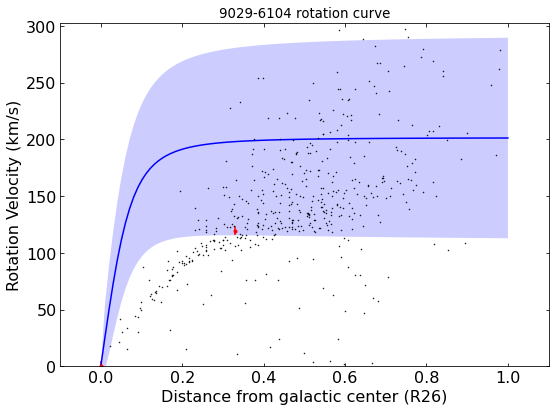

[Errno 2] No such file or directory: 'Hessians/9876-6102_Hessian.npy'


<Figure size 432x288 with 0 Axes>

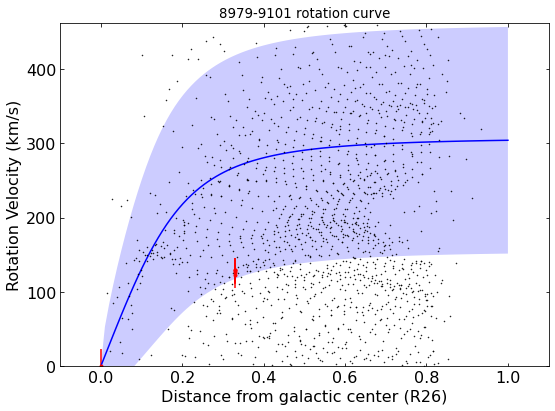

<Figure size 432x288 with 0 Axes>

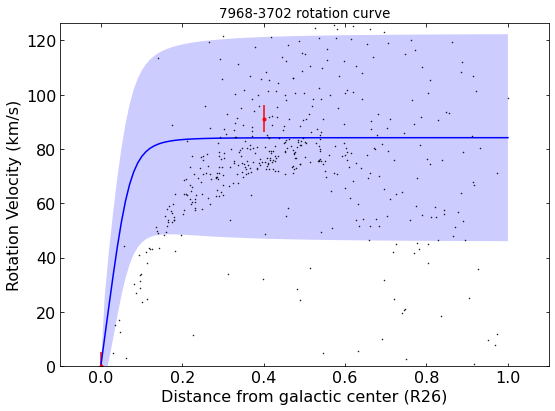

<Figure size 432x288 with 0 Axes>

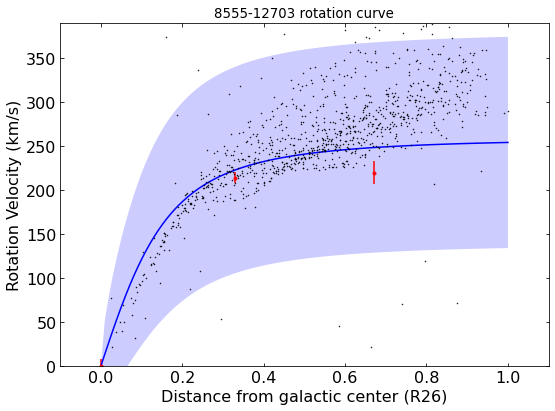

<Figure size 432x288 with 0 Axes>

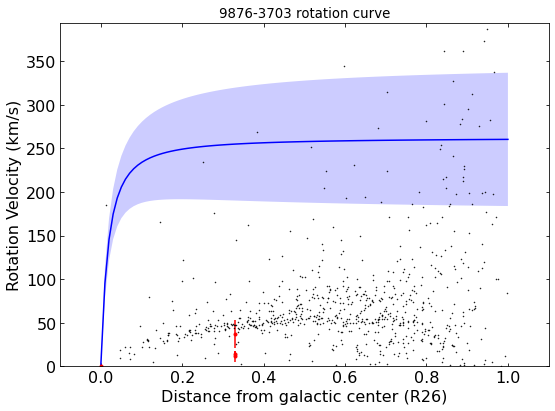

<Figure size 432x288 with 0 Axes>

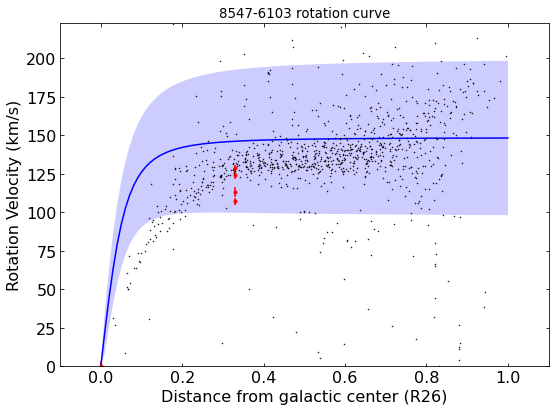

[Errno 2] No such file or directory: 'Hessians/8949-12705_Hessian.npy'


<Figure size 432x288 with 0 Axes>

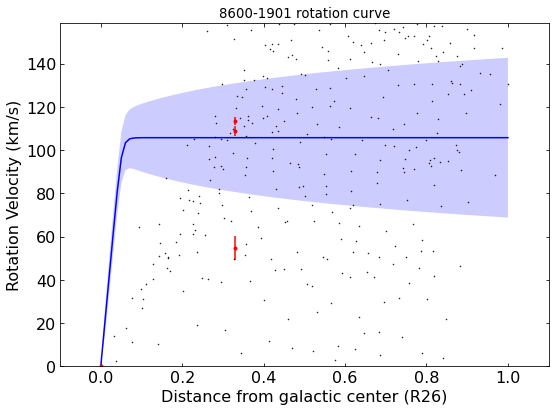

<Figure size 432x288 with 0 Axes>

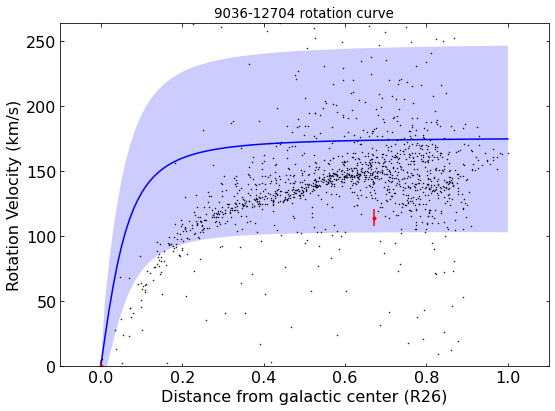

<Figure size 432x288 with 0 Axes>

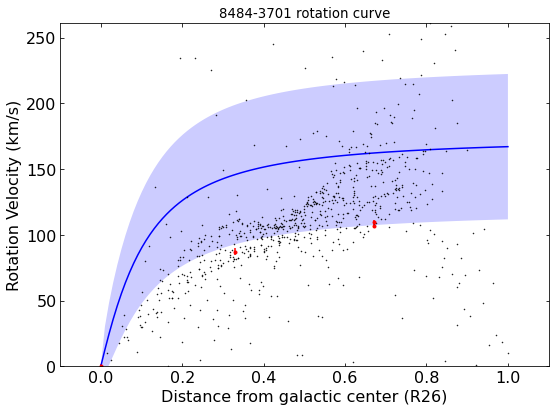

<Figure size 432x288 with 0 Axes>

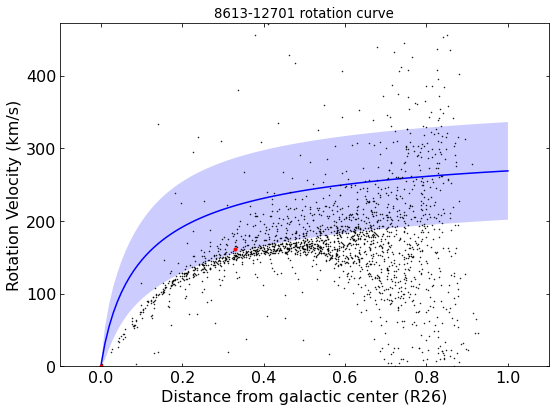

[Errno 2] No such file or directory: 'Hessians/8953-9102_Hessian.npy'


<Figure size 432x288 with 0 Axes>

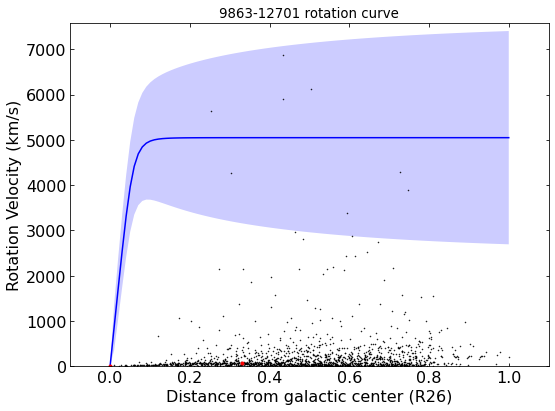

[Errno 2] No such file or directory: 'Hessians/8479-6102_Hessian.npy'


<Figure size 432x288 with 0 Axes>

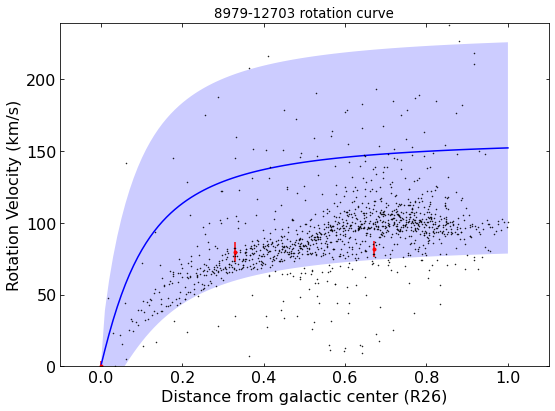

[Errno 2] No such file or directory: 'Hessians/8949-3704_Hessian.npy'


<Figure size 432x288 with 0 Axes>

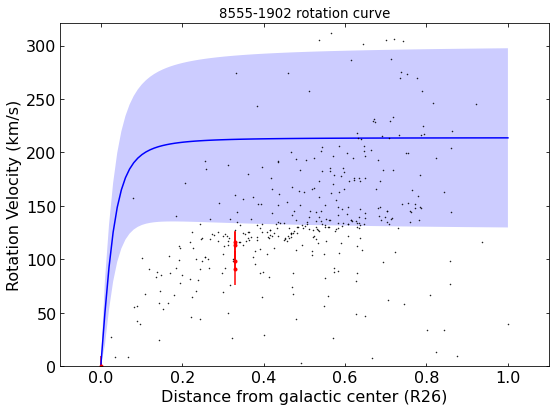

<Figure size 432x288 with 0 Axes>

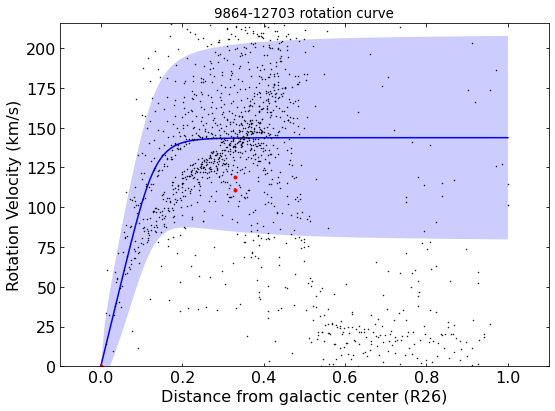

<Figure size 432x288 with 0 Axes>

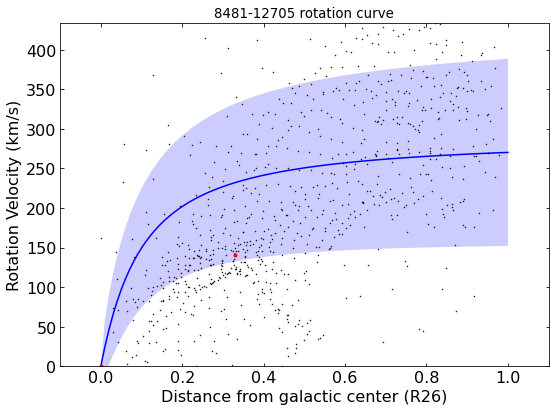

<Figure size 432x288 with 0 Axes>

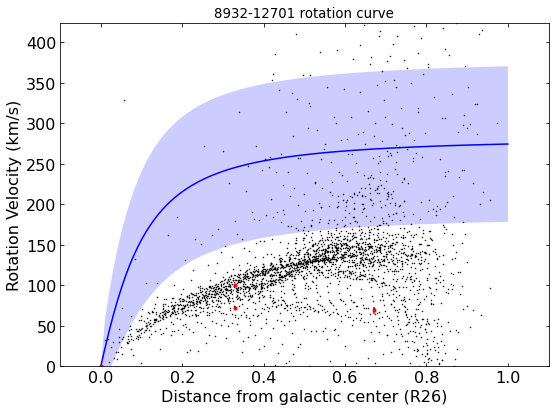

<Figure size 432x288 with 0 Axes>

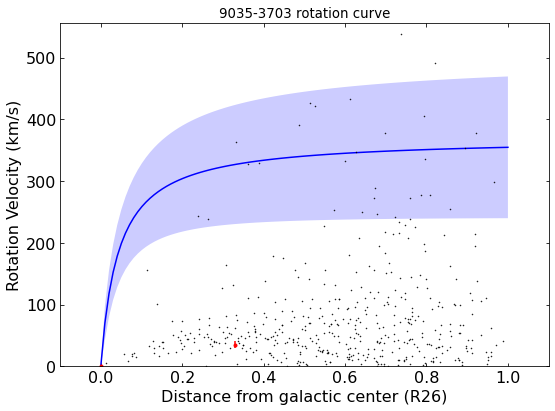

[Errno 2] No such file or directory: 'Hessians/8949-9102_Hessian.npy'
[Errno 2] No such file or directory: 'Hessians/9037-9102_Hessian.npy'
SVD did not converge


<Figure size 432x288 with 0 Axes>

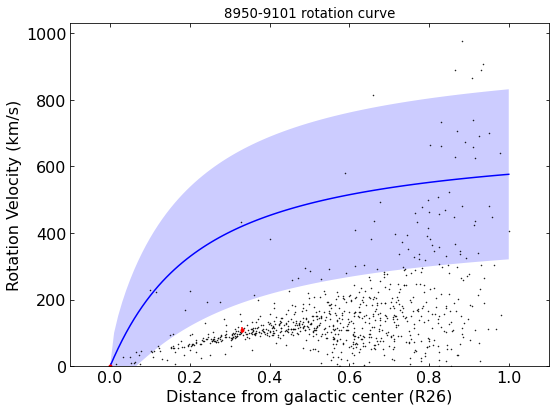

<Figure size 432x288 with 0 Axes>

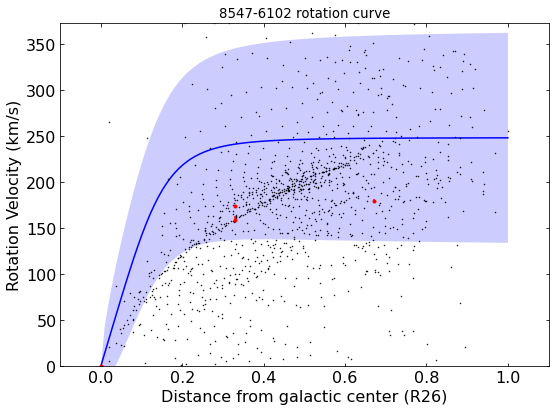

<Figure size 432x288 with 0 Axes>

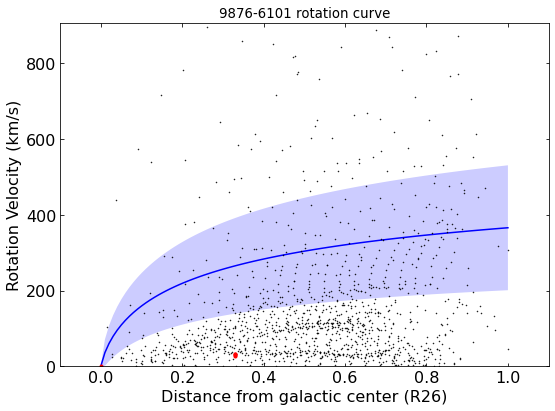

<Figure size 432x288 with 0 Axes>

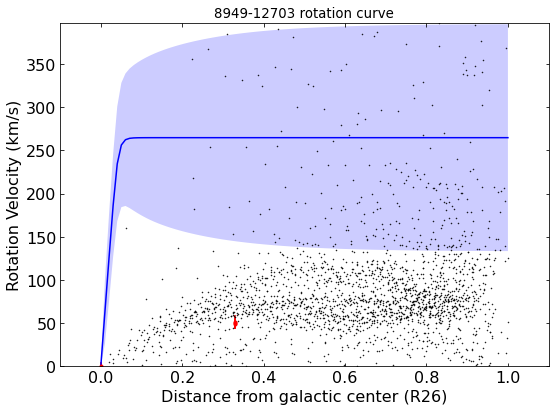

<Figure size 432x288 with 0 Axes>

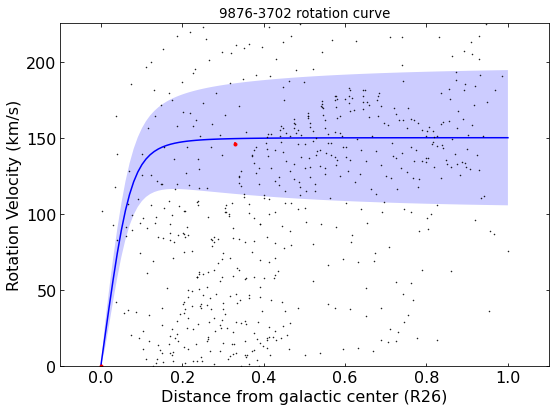

[Errno 2] No such file or directory: 'Hessians/8932-3701_Hessian.npy'


<Figure size 432x288 with 0 Axes>

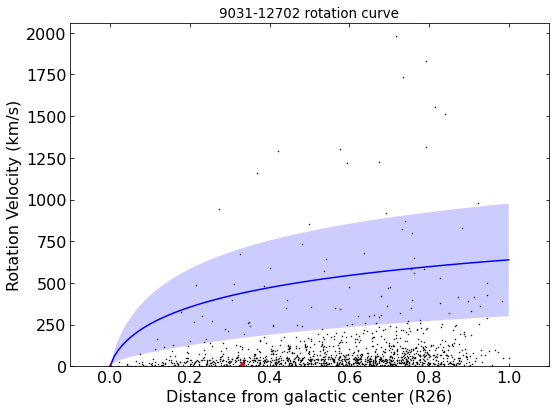

<Figure size 432x288 with 0 Axes>

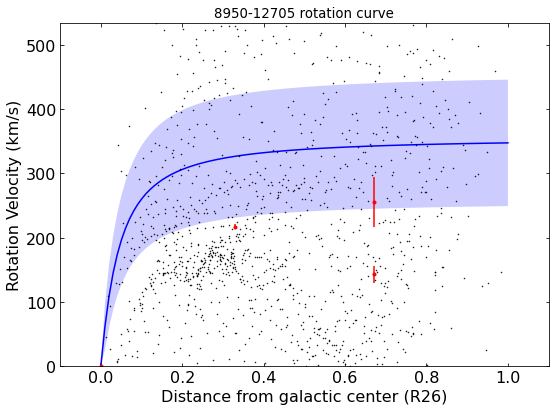

<Figure size 432x288 with 0 Axes>

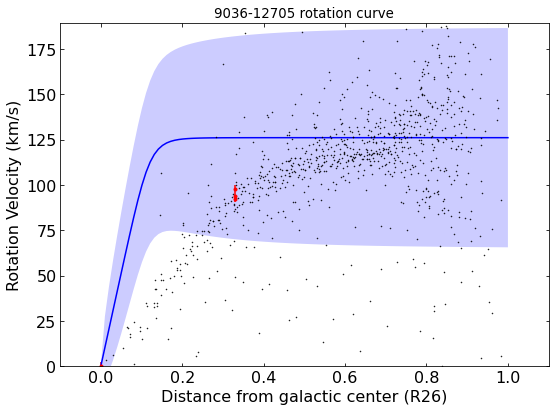

<Figure size 432x288 with 0 Axes>

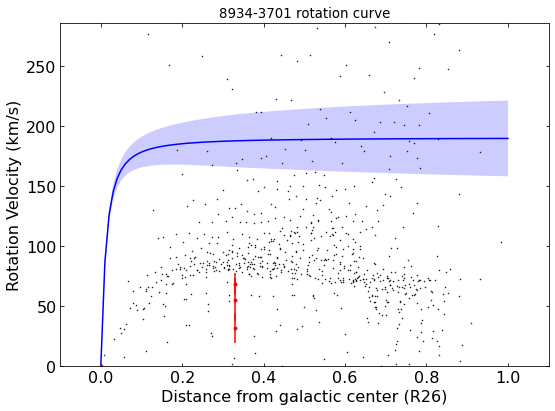

<Figure size 432x288 with 0 Axes>

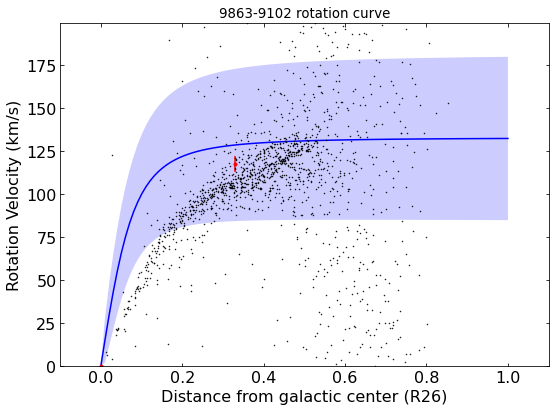

<Figure size 432x288 with 0 Axes>

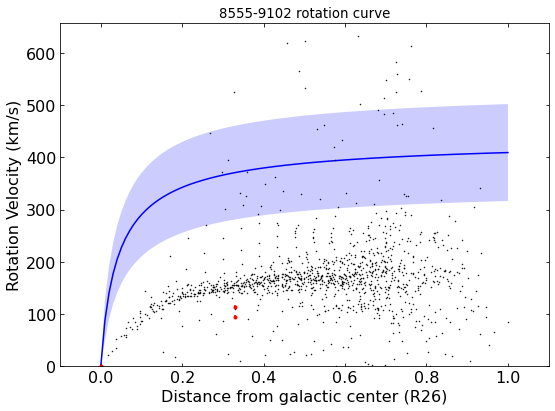

<Figure size 432x288 with 0 Axes>

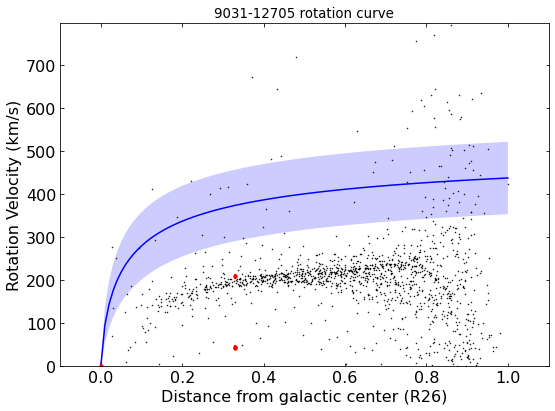

<Figure size 432x288 with 0 Axes>

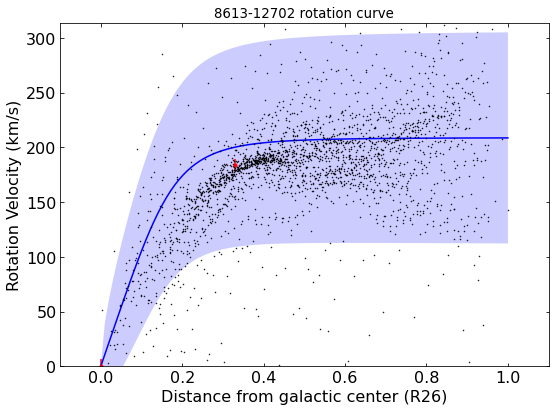

<Figure size 432x288 with 0 Axes>

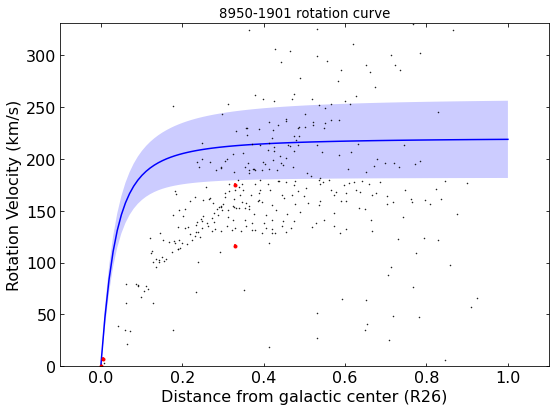

<Figure size 432x288 with 0 Axes>

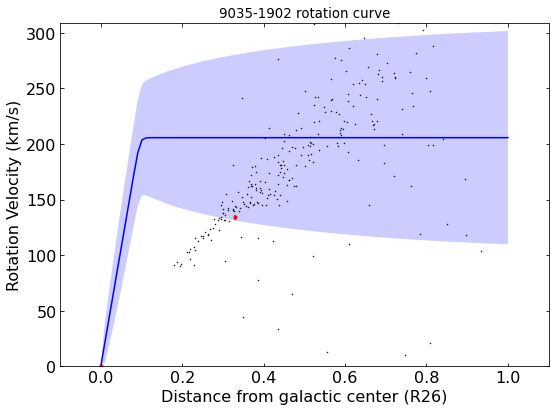

[Errno 2] No such file or directory: 'Hessians/8932-6102_Hessian.npy'


In [130]:
for i in multiple_sga:
    try:
        findIdx = DESI_MaNGA_final['sga_id'] == i
        rotcurve(findIdx, DESI_MaNGA_final)
#     except FileNotFoundError as e:
#         print(e)
    except Exception as e:
        print(e)
    
    #break

In [ ]:
DESI_MaNGA_final

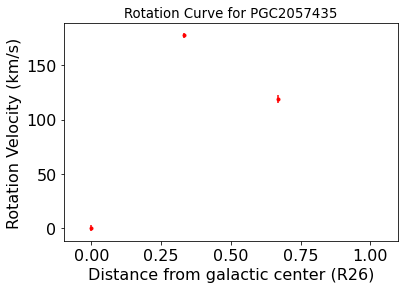

In [42]:
#Use this to plot DESI observations that do not have a MaNGA best-fit curve to match with
galaxy_name = 'PGC2057435'
galaxy_idx = final_data['GALAXY'] == galaxy_name

desiPlots(galaxy_idx, final_data)

## Save RA and DEC file for galaxy overlay

In [43]:
coords_data = DESI_MaNGA_final['target_ra', 'target_dec']
coords_data

target_ra,target_dec
float64,float64
247.213743174323,42.765439952542
247.216100924555,42.7668479232987
195.878275054505,28.0914354554148
195.880147500007,28.0922920375178
241.278445498263,42.0351012353597
241.278666350013,42.0395653919508
241.278666350013,42.0395653919508
241.27855592026,42.0373333137081
241.278445498263,42.0351012353597


In [44]:
#coords_data.write('coords_data.fits', overwrite=True)

In [45]:
DESI_MaNGA_final.write('DESI_MaNGA_results.txt', overwrite=True, format='ascii.commented_header')

In [80]:
#Add radius column in arcseconds 

#coords_data['radius'] = coords_data['radius'].astype(float)
coords_data['radius'] = 1
coords_data.remove_column('color')
coords_data.write('coords_data.fits', overwrite=True)
coords_data

target_ra,target_dec,legacy_radius,radius
float64,float64,float64,float64
247.213743174323,42.765439952542,0.001,1.0
247.216100924555,42.7668479232987,0.001,1.0
195.878275054505,28.0914354554148,0.001,1.0
195.880147500007,28.0922920375178,0.001,1.0
241.278445498263,42.0351012353597,0.001,1.0
241.278666350013,42.0395653919508,0.001,1.0
241.278666350013,42.0395653919508,0.001,1.0
241.27855592026,42.0373333137081,0.001,1.0
241.278445498263,42.0351012353597,0.001,1.0


In [84]:
DESI_MaNGA

NameError: name 'DESI_MaNGA' is not defined